In [1]:
import json
import numpy as np
import pandas as pd
import sentencepiece as spm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# load trained tokenizer
sp_ja = spm.SentencePieceProcessor(model_file='ja.model')
sp_en = spm.SentencePieceProcessor(model_file='en.model')

# special tokens
vocabs = [sp_ja.id_to_piece(id) for id in range(sp_ja.get_piece_size())]
sos_token = np.where(np.array(vocabs)=='<s>')[0][0]
eos_token = np.where(np.array(vocabs)=='</s>')[0][0]
pad_token = np.where(np.array(vocabs)=='<pad>')[0][0]

# load token series
ja_arr = pd.read_csv('train_ja.csv', header=None).to_numpy()
en_arr = pd.read_csv('train_en.csv', header=None).to_numpy()
    
def generate_padding_mask(seq, pad_idx=0):
    batch_size, seq_len = seq.size()
    mask = (seq == pad_idx)
    mask = mask.repeat(1,seq_len).reshape(batch_size,1,seq_len,seq_len)
    return mask
    
class SeqDataset(torch.utils.data.Dataset):
    def __init__(self, source_seq, target_seq):
        self.source_seq = torch.tensor(source_seq).to(device)
        self.target_seq = torch.tensor(target_seq).to(device)
    
    def __len__(self):
        return len(self.source_seq)

    def __getitem__(self, idx):
        # sample X & Y
        sample_source = self.source_seq[idx]
        sample_target = self.target_seq[idx]

        # attention mask
        #sample_mask   = generate_padding_mask(sample_source, pad_token)
        
        return sample_source, sample_target

## Preprocessing

In [119]:
# load dataset
df = pd.read_parquet('corpus/tanaka-corpus.parquet')
df = df[(df.ja.map(len)<50)&(df.en.map(len)<50)]

# add start and end token
df.ja = df.ja.map(lambda txt: '<s>'+txt+'</s>')
df.en = df.en.map(lambda txt: '<s>'+txt+'</s>')

df

,id,ja,en
0,303697_100000,<s>彼は忙しい生活の中で家族と会うことがない。</s>,<s>He doesn't see his family in his busy life....
2,303695_100002,<s>彼は忙しいので、君に会えない。</s>,"<s>In as much as he is busy, he can't meet you..."
4,303693_100004,<s>彼は忙しいと言いました。</s>,<s>He said he was busy.</s>
5,303692_100005,<s>彼は忙しいですか。</s>,<s>Is he busy?</s>
6,303691_100006,<s>彼は忙しいからと私の頼みを断った。</s>,"<s>He declined my request, saying that he was ..."
...,...,...,...
147869,303704_99993,<s>彼は望みを捨てた。</s>,<s>He gave up hope.</s>
147870,303703_99994,<s>彼は暴力に訴えざるを得なかった。</s>,<s>He was compelled to resort to violence.</s>
147872,303701_99996,<s>彼は忙しすぎるんだよ。</s>,<s>He's too busy.</s>
147874,303699_99998,<s>彼は忙しかった。</s>,<s>He was busy.</s>


In [120]:
# save training file
df.ja.to_csv('corpus/ja.txt', header=None, index=None, sep=' ', mode='a')
df.en.to_csv('corpus/en.txt', header=None, index=None, sep=' ', mode='a')

# train tokenizer
spm.SentencePieceTrainer.train(input='corpus/ja.txt', model_prefix='ja', vocab_size=4000, user_defined_symbols=['<s>', '</s>', '<pad>'])
spm.SentencePieceTrainer.train(input='corpus/en.txt', model_prefix='en', vocab_size=4000, user_defined_symbols=['<s>', '</s>', '<pad>'])

In [121]:
# load trained tokenizer
sp_ja = spm.SentencePieceProcessor(model_file='ja.model')
sp_en = spm.SentencePieceProcessor(model_file='en.model')

# test
print(sp_ja.encode("<s>彼は忙しい生活の中で家族と会うことがない。</s>"))
print(sp_ja.encode("<s>彼は忙しい生活の中で家族と会うことがない。</s>", out_type=str))
print(sp_en.encode("<s>He doesn't see his family in his busy life.</s>"))
print(sp_en.encode("<s>He doesn't see his family in his busy life.</s>", out_type=str))

vocabs = [sp_ja.id_to_piece(id) for id in range(sp_ja.get_piece_size())]
print(vocabs[:10])
vocabs = [sp_en.id_to_piece(id) for id in range(sp_ja.get_piece_size())]
print(vocabs[:10])

# special tokens
sos_token = np.where(np.array(vocabs)=='<s>')[0][0]
eos_token = np.where(np.array(vocabs)=='</s>')[0][0]
pad_token = np.where(np.array(vocabs)=='<pad>')[0][0]

[4, 1, 17, 3966, 195, 470, 539, 541, 22, 860, 1226, 5, 2]
['▁', '<s>', '彼は', '忙', 'しい', '生活', 'の中で', '家族', 'と', '会う', 'ことがない', '。', '</s>']
[4, 1, 22, 167, 39, 21, 27, 113, 36, 389, 23, 36, 414, 217, 6, 2]
['▁', '<s>', 'He', '▁does', 'n', "'", 't', '▁see', '▁his', '▁family', '▁in', '▁his', '▁busy', '▁life', '.', '</s>']
['<unk>', '<s>', '</s>', '<pad>', '▁', '。', '<', '>', 'は', 'e']
['<unk>', '<s>', '</s>', '<pad>', '▁', '▁"', '.', '<', '"', '>"']


In [122]:
def encode(sentence, encoder, sos_token):
    encoded = encoder.encode(sentence)
    while encoded[0] != sos_token:
        encoded = encoded[1:]
    return encoded

encoded_ja = df.ja.map(lambda x: encode(x, sp_ja, sos_token))
encoded_en = df.en.map(lambda x: encode(x, sp_en, sos_token))

encoded_ja.to_json('tokenized_ja.json', orient='records')
encoded_en.to_json('tokenized_en.json', orient='records')

In [123]:
# load token series
with open("tokenized_ja.json", 'r') as f:
    encoded_ja = pd.Series(json.load(f))

with open("tokenized_en.json", 'r') as f:
    encoded_en = pd.Series(json.load(f))

# filter out longer sentences
idxs = (encoded_ja.map(len) <= 20)&(encoded_en.map(len) <= 20)
encoded_ja = encoded_ja[idxs]
encoded_en = encoded_en[idxs]

# pad all sentence to uniform length
def sequence_padder(pad_token, target_length):
    def pad_sequence(input_seq):
        padded_sequence = input_seq[:]
        while len(padded_sequence) < target_length:
            padded_sequence += [pad_token]
        return padded_sequence
    return pad_sequence
    
padded_ja = encoded_ja.map(sequence_padder(pad_token, 20))
padded_en = encoded_en.map(sequence_padder(pad_token, 20))

ja_arr = np.array(padded_ja.to_list())
en_arr = np.array(padded_en.to_list())

pd.DataFrame(ja_arr).to_csv('train_ja.csv', index=False, header=False)
pd.DataFrame(en_arr).to_csv('train_en.csv', index=False, header=False)

In [7]:
def generate_padding_mask(seq, pad_idx=0):
    batch_size, seq_len = seq.size()
    mask = (seq != pad_idx)
    mask = mask.repeat(1,seq_len).reshape(batch_size,1,seq_len,seq_len)
    return mask
    
class SeqDataset(torch.utils.data.Dataset):
    def __init__(self, source_seq, target_seq):
        self.source_seq = torch.tensor(source_seq).to(device)
        self.target_seq = torch.tensor(target_seq).to(device)
    
    def __len__(self):
        return len(self.source_seq)

    def __getitem__(self, idx):
        # sample X & Y
        sample_source = self.source_seq[idx]
        sample_target = self.target_seq[idx]

        # attention mask
        #sample_mask   = generate_padding_mask(sample_source, pad_token)
        
        return sample_source, sample_target

dataset = SeqDataset(ja_arr[:10000], en_arr[:10000])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

## Network

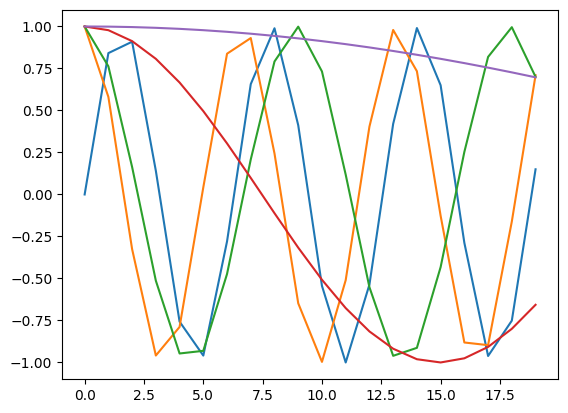

In [112]:
# fixed sinusoidal positional embedding

def compute_PE(max_pos, d):

    PE = np.zeros((max_pos, d))

    for pos in range(max_pos):
        for i in range(0, d, 2):
            PE[pos, i] = np.sin(pos / (5 ** (2 * i / 128)))
            if i + 1 < d:
                PE[pos, i + 1] = np.cos(pos / (5 ** (2 * i / 128)))

    return PE

PE = compute_PE(20, 128)

plt.plot(PE[:,0])
plt.plot(PE[:,3])
plt.plot(PE[:,15])
plt.plot(PE[:,63])
plt.plot(PE[:,127])

In [210]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, embed_dim, dropout=0.2):
        super(MultiHeadAttention, self).__init__()
        
        assert embed_dim % num_heads == 0
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        # Define the linear layers for queries, keys, and values
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        
        # Final output projection
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        
        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, source_arr, target_arr, mask=None):
        batch_size, seq_len, ebd_size = target_arr.size()
        
        # Linear projections for Q, K, V
        Q = self.q_proj(target_arr[:,:seq_len,:])  # (batch_size, seq_len, head_dim)
        K = self.k_proj(source_arr[:,:seq_len,:])
        V = self.v_proj(source_arr[:,:seq_len,:])
        
        # Reshape and split the heads
        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)  # (batch_size, num_heads, seq_len, head_dim)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        
        # Scaled dot-product attention
        attn_weights = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)  # (batch_size, num_heads, seq_len, seq_len)
        
        # Apply mask (if provided)
        if mask is not None:
            attn_weights = attn_weights.masked_fill(mask[...,:seq_len,:seq_len], -1e4)  # align attention mask
        
        # Apply softmax to get the attention weights
        attn_weights = F.softmax(attn_weights, dim=-1)  # (batch_size, num_heads, seq_len, seq_len)
        
        # Apply dropout to the attention weights
        attn_weights = self.dropout(attn_weights)
        
        # Weighted sum of the values
        attn_output = torch.matmul(attn_weights, V)  # (batch_size, num_heads, seq_len, head_dim)
        
        # Concatenate the heads
        attn_output = attn_output.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.embed_dim)  # (batch_size, seq_len, embed_dim)
        
        # Final linear projection
        output = self.out_proj(attn_output)  # (batch_size, seq_len, embed_dim)
        
        return output

In [211]:
class EncoderBlock(nn.Module):
    def __init__(self, num_heads, input_dimension, seq_size):
        super(EncoderBlock, self).__init__()

        self.attention = MultiHeadAttention(num_heads, input_dimension, dropout=0.1)
        self.norm1 = nn.LayerNorm(input_dimension)
        self.norm2 = nn.LayerNorm(input_dimension)
        self.fc1 = nn.Linear(input_dimension, input_dimension)
        self.fc2 = nn.Linear(input_dimension, input_dimension)
        
    def forward(self, source_arr, mask=None):
        out = self.norm1(source_arr)
        out = self.attention(source_arr, source_arr, mask=mask)  # self attention
        out = out + source_arr
        out = self.norm2(out)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

class Encoder(nn.Module):
    def __init__(self, attention_heads, input_dim, seq_size):
        super(Encoder, self).__init__()
        self.encoder_block1 = EncoderBlock(attention_heads, input_dim, seq_size)
        self.encoder_block2 = EncoderBlock(attention_heads, input_dim, seq_size)
        self.encoder_block3 = EncoderBlock(attention_heads, input_dim, seq_size)
        self.encoder_block4 = EncoderBlock(attention_heads, input_dim, seq_size)
        self.norm = nn.LayerNorm((seq_size, input_dim))

    def forward(self, source_arr, mask=None):
        out = self.encoder_block1(source_arr, mask=mask)
        out = self.encoder_block2(out, mask=mask)
        out = self.encoder_block3(out, mask=mask)
        out = self.encoder_block4(out, mask=mask)
        out = self.norm(out)
        return out

In [212]:
class DecoderBlock(nn.Module):
    def __init__(self, num_heads, input_dim, seq_len):
        super(DecoderBlock, self).__init__()

        self.self_attention = MultiHeadAttention(num_heads, input_dim, dropout=0.1)
        self.cross_attention = MultiHeadAttention(num_heads, input_dim, dropout=0.1)
        self.register_buffer("mask", torch.triu(torch.ones((seq_len,seq_len), dtype=torch.bool)))
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.norm3 = nn.LayerNorm(input_dim)
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.fc2 = nn.Linear(input_dim, input_dim)
    
    def forward(self, target_arr, source_arr, mask=None):

        batch_size, seq_len, ebd_size = target_arr.size()
        
        # self attention blocks
        self_out = self.norm1(target_arr)
        self_out = self.self_attention(target_arr, target_arr, mask=self.mask.expand(batch_size,1,-1,-1))
        self_out = self_out + target_arr
        
        # cross attention
        cross_out = self.norm2(self_out)
        cross_out = self.cross_attention(source_arr, self_out, mask=mask)  # align seq_len
        cross_out = cross_out + self_out

        # linear outputs
        fc_out = self.norm3(cross_out)
        fc_out = self.fc1(fc_out)
        fc_out = F.relu(fc_out)
        fc_out = self.fc2(fc_out)
        fc_out = fc_out + cross_out

        return fc_out


class Decoder(nn.Module):
    def __init__(self, attention_heads, input_dim, seq_size, output_vocab):
        super(Decoder, self).__init__()
        self.decoderBlock1 = DecoderBlock(attention_heads, input_dim, seq_size)
        self.decoderBlock2 = DecoderBlock(attention_heads, input_dim, seq_size)
        self.decoderBlock3 = DecoderBlock(attention_heads, input_dim, seq_size)
        self.decoderBlock4 = DecoderBlock(attention_heads, input_dim, seq_size)
        
        self.norm = nn.LayerNorm(input_dim)
        self.readout = nn.Linear(input_dim, output_vocab)
    
    def forward(self, target_input, source_input, mask=None):
        # attention blocks
        out = self.decoderBlock1(target_input, source_input, mask=mask)
        out = self.decoderBlock2(out, source_input, mask=mask)
        out = self.decoderBlock3(out, source_input, mask=mask)
        out = self.decoderBlock4(out, source_input, mask=mask)

        # final readout layers
        out = self.norm(out)
        out = self.readout(out)

        return out

In [213]:
class Transformer(nn.Module):
    def __init__(self, seq_size, ebd_size, attention_heads, source_ebd, target_ebd, output_vocab):
        
        super(Transformer, self).__init__()
        self.source_ebd = source_ebd
        self.target_ebd = target_ebd
        self.Encoder = Encoder(attention_heads, ebd_size, seq_size)
        self.Decoder = Decoder(attention_heads, ebd_size, seq_size, output_vocab)
        self.register_buffer('PE_tensor', torch.tensor(PE).float()[:seq_size, :ebd_size])
    
    def encode(self, source_seq, mask=None):
        # transform token sequence into embedding
        source_arr = self.source_ebd(source_seq)
        batch_size, seq_len, ebd_size = source_arr.size()

        # sum PE tensor
        source_arr += self.PE_tensor
        
        # input into transformer
        encoder_out = self.Encoder(source_arr, mask=mask)
        return encoder_out

    def decode(self, encoder_out, target_seq, mask=None):
        # format embedding
        target_arr = self.target_ebd(target_seq)
        batch_size, seq_len, ebd_size = target_arr.size()
        
        # sum PE tensor
        target_arr += self.PE_tensor[:seq_len]
        
        # input into decoder
        decoder_out = self.Decoder(target_arr, encoder_out, mask=mask)
        return decoder_out

    def forward(self, source_seq, target_seq, mask=None):
        encoder_out = self.encode(source_seq, mask=mask)
        decoder_out = self.decode(encoder_out, target_seq, mask=mask)
        return decoder_out

seq_len = 19
ebd_size = 128
num_heads = 16
input_vocab = 4000
output_vocab = 4000

embedding_ja = nn.Embedding(input_vocab, ebd_size)
embedding_en = nn.Embedding(output_vocab, ebd_size)
model = Transformer(seq_len, ebd_size, num_heads, embedding_ja, embedding_en, output_vocab)
model = model.to(device)
test = torch.tensor(np.arange(4*seq_len).reshape(4, seq_len)).to(device)
out = model(test, test)

In [214]:
dataset = SeqDataset(ja_arr[:10000], en_arr[:10000])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)

# Loss function & optimizer
loss_fn = nn.CrossEntropyLoss(ignore_index=pad_token)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for (source_batch, target_batch) in dataloader:
        mask_batch = generate_padding_mask(source_batch, pad_idx=pad_token)

        # with autocast():
        teacher_forcing = (torch.rand(1) < max(0.2, 1-epoch*0.01))
        if teacher_forcing:  # teacher forcing training
            # generate with true label
            predicted_seq = model(source_batch[:,1:], target_batch[:,:-1], mask=mask_batch[:,:,1:,1:])
            
            # flatten prediction and target before calculating loss
            predicted_seq_flat = predicted_seq.view(-1, predicted_seq.size(-1))
            target_flat = target_batch[:, 1:].contiguous().view(-1)
    
            # compute loss
            loss = loss_fn(predicted_seq_flat, target_flat)
            
        else:  # autoregressive training
            loss = torch.tensor([0.], device=device)
            # get encoder output
            encoder_output = model.encode(source_batch[:,1:], mask=mask_batch[:,:,1:,1:])
            
            # Initialize the target sequence
            batch_size, seq_len = source_batch.size()
            predicted_seq = torch.tensor([sos_token]*batch_size, device=device).unsqueeze(1)
            
            # autoregressive generation loop
            for i in range(seq_len-1):
                
                # format prediction target
                target_flat = target_batch[:, i+1].view(-1)

                # continue to next batch if all targets are pad token
                if torch.all(target_flat == pad_token):
                    break
        
                # get decoder prediction
                decoder_output = model.decode(encoder_output, predicted_seq)[:,-1,:]
                decoder_output_flat = decoder_output.view(-1, decoder_output.size(-1))
        
                # compute and cumulate loss
                loss += loss_fn(decoder_output_flat, target_flat)
        
                # generate next token and merge to decoder input
                next_tokens = decoder_output.argmax(dim=-1)
                predicted_seq = torch.cat([predicted_seq, next_tokens.unsqueeze(1)], dim=1)
            
            loss /= i

        # update model
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()

    # Print average loss for the epoch
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(dataset):.4f}")

Epoch [1/100], Loss: 0.0214
Epoch [2/100], Loss: 0.0168
Epoch [3/100], Loss: 0.0153
Epoch [4/100], Loss: 0.0151
Epoch [5/100], Loss: 0.0137
Epoch [6/100], Loss: 0.0137
Epoch [7/100], Loss: 0.0125
Epoch [8/100], Loss: 0.0116
Epoch [9/100], Loss: 0.0115
Epoch [10/100], Loss: 0.0106
Epoch [11/100], Loss: 0.0101
Epoch [12/100], Loss: 0.0109
Epoch [13/100], Loss: 0.0096
Epoch [14/100], Loss: 0.0090
Epoch [15/100], Loss: 0.0089
Epoch [16/100], Loss: 0.0085
Epoch [17/100], Loss: 0.0098
Epoch [18/100], Loss: 0.0089
Epoch [19/100], Loss: 0.0079
Epoch [20/100], Loss: 0.0072


KeyboardInterrupt: 

In [216]:
model.eval()

#predicted_seq = model(torch.randint(4000, source_batch.size())[:,1:].to(device), target_batch[:,:-1], mask=mask_batch[:,:,:-1,:-1])
predicted_seq = model(source_batch[:,1:], target_batch[:,:-1], mask=mask_batch[:,:,:-1,:-1])
seq = torch.argmax(predicted_seq, dim=-1).detach().cpu().numpy().astype(int)

for i in range(len(seq)):
    print(sp_ja.decode([int(j) for j in source_batch[i]]))
    print(sp_en.decode([int(j) for j in target_batch[i]]))
    print(sp_en.decode([int(j) for j in seq[i]]))

<s>彼は喫煙をやめた。</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
<s>He stopped smoking.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
He ran smoking.</s>.....''HeHeHeHeHeHeHe
<s>彼は場外にボールを飛ばした。</s><pad><pad><pad><pad><pad><pad><pad><pad>
<s>He hit the ball out of bounds.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad>
He ran the car out of thes.</s>.........
<s>彼は新しい車が気に入っている。</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
<s>He is pleased with his new car.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
He is busy with his father car.</s>..........
<s>彼は森で道に迷った。</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
<s>He lost his way in the woods.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
He succeeded his way in the examination.</s>..........
<s>彼は人付き合いがよくない。</s><pad><pad><pad><pad><pad><pad><pad><pad>
<s>He doesn't mix well.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
He doesn't know today.</s>......

In [217]:
#def inference(source_sentence):
source_sentence = '彼は喫煙をやめた。'
tokenized_sentence = sp_ja.encode(source_sentence)
if sos_token not in tokenized_sentence:
    tokenized_sentence = [sos_token] + tokenized_sentence
if eos_token not in tokenized_sentence:
    tokenized_sentence = tokenized_sentence + [eos_token]
if len(tokenized_sentence) < 20:
    tokenized_sentence = tokenized_sentence + [pad_token] * (20 - len(tokenized_sentence))
print(tokenized_sentence)

source_arr = torch.tensor(tokenized_sentence).to(device).reshape(1,-1)
mask = generate_padding_mask(source_arr, pad_idx=pad_token)

encoder_output = model.encode(source_arr[:,1:], mask=mask)
encoder_output

[1, 4, 17, 90, 53, 5, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


tensor([[[-0.0228,  0.0376,  0.0029,  ..., -0.0605,  0.0553,  0.0229],
         [-0.1214, -0.1360,  0.2358,  ...,  0.3978, -0.0516, -0.1588],
         [ 0.0501,  0.0189,  0.0211,  ..., -0.0135,  0.0447,  0.0778],
         ...,
         [-0.0520,  0.2624,  0.5492,  ...,  2.5712, -0.2171, -0.2020],
         [-0.0595,  0.1936,  0.5782,  ...,  2.3844, -0.2406, -0.1877],
         [-0.0067,  0.1449,  0.5475,  ...,  2.5259, -0.2517, -0.1820]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [218]:
batch_size = 1

# Step 2: Initialize the target sequence with <sos> token
target_seq = torch.tensor([sos_token]*batch_size, device=device).unsqueeze(1)  # Shape: (1, 1)

# Step 3: Autoregressive generation loop
for i in range(19):
    # Get decoder output
    decoder_output = model.decode(encoder_output.repeat(batch_size,1,1), target_seq)
    
    # # Extract the last token from the decoder output (e.g., logits)
    next_tokens = decoder_output[:, -1, :].argmax(dim=-1)  # Shape: (1,)
    
    # Append the generated token to the target sequence
    target_seq = torch.cat([target_seq, next_tokens.unsqueeze(1)], dim=1)
    
    # Stop if <eos> token is generated
    if next_tokens.item() == eos_token:
        break

print(target_seq)
output = [int(i) for i in target_seq[0].detach().cpu()]
sp_en.decode(output)

tensor([[ 1, 22, 19, 18, 12, 12,  6,  6,  6,  6,  6,  6,  2]], device='cuda:0')


'<s>He is a to to......</s>'